# Predictive Maintenance for Industrial IoT
## Step 5: Model Evaluation & Selection

This notebook covers:
1. Cross-validation for robust model evaluation
2. Hyperparameter tuning for model optimization
3. Final model selection based on performance metrics
4. Saving the best model for deployment


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit, StratifiedKFold
)
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, 
    precision_recall_fscore_support, confusion_matrix, 
    classification_report, roc_curve, auc
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Import KerasRegressor from scikeras instead
from scikeras.wrappers import KerasRegressor
import warnings

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.2)
warnings.filterwarnings('ignore')

# Display all columns in pandas dataframes
pd.set_option('display.max_columns', None)


### Step 5.1: Load and Prepare Data


In [3]:
# For demonstration, we'll load the data directly
# In a real workflow, you would load the processed data from the previous notebook

# Define paths to dataset files
data_dir = '../aps_failure_at_scania_trucks'
train_file = os.path.join(data_dir, 'aps_failure_training_set.csv')
test_file = os.path.join(data_dir, 'aps_failure_test_set.csv')

# Load the training and test datasets
print(f"Loading training data from {train_file}")
train_data = pd.read_csv(train_file)

print(f"Loading test data from {test_file}")
test_data = pd.read_csv(test_file)

# Extract labels (class column)
y_train = train_data['class'].map({'neg': 0, 'pos': 1})
y_test = test_data['class'].map({'neg': 0, 'pos': 1})

# Extract features (all columns except 'class')
X_train = train_data.drop('class', axis=1)
X_test = test_data.drop('class', axis=1)

print(f"Loaded training data: {X_train.shape} features, {y_train.shape} labels")
print(f"Loaded test data: {X_test.shape} features, {y_test.shape} labels")

# Preprocess data
print("\nPreprocessing data...")

# Replace 'na' with NaN
X_train = X_train.replace('na', np.nan)
X_test = X_test.replace('na', np.nan)

# Convert to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Handle missing values using median imputation
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit imputer on training data and transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert back to DataFrame
X_train_processed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_processed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_processed),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_processed),
    columns=X_test.columns
)

print("Preprocessing complete.")

# Feature selection - for demonstration, we'll use a simple approach
# In practice, we would use the top features identified in the previous notebook
from sklearn.ensemble import RandomForestClassifier

# Calculate feature importance
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})
top_features = feature_importance.sort_values('importance', ascending=False)
top_20_features = top_features.head(20)['feature'].tolist()

# Select top features
X_train_top = X_train_scaled[top_20_features]
X_test_top = X_test_scaled[top_20_features]

print(f"Selected {len(top_20_features)} top features for modeling.")
print(f"X_train_top shape: {X_train_top.shape}")
print(f"X_test_top shape: {X_test_top.shape}")


Loading training data from ../aps_failure_at_scania_trucks\aps_failure_training_set.csv
Loading test data from ../aps_failure_at_scania_trucks\aps_failure_test_set.csv
Loaded training data: (60000, 170) features, (60000,) labels
Loaded test data: (16000, 170) features, (16000,) labels

Preprocessing data...
Preprocessing complete.
Selected 20 top features for modeling.
X_train_top shape: (60000, 20)
X_test_top shape: (16000, 20)


### Step 5.2: Cross-Validation for Classification Models


Evaluating models with 5-fold cross-validation...

Evaluating Random Forest...
  Scoring with accuracy...
    Mean accuracy: 0.9795 ± 0.0011
  Scoring with precision...
    Mean precision: 0.4432 ± 0.0146
  Scoring with recall...
    Mean recall: 0.8900 ± 0.0130
  Scoring with f1...
    Mean f1: 0.5916 ± 0.0138
  Scoring with roc_auc...
    Mean roc_auc: 0.9840 ± 0.0058

Evaluating XGBoost...
  Scoring with accuracy...
    Mean accuracy: 0.9755 ± 0.0015
  Scoring with precision...
    Mean precision: 0.3984 ± 0.0157
  Scoring with recall...
    Mean recall: 0.9170 ± 0.0075
  Scoring with f1...
    Mean f1: 0.5553 ± 0.0159
  Scoring with roc_auc...
    Mean roc_auc: 0.9864 ± 0.0041

Cross-validation summary:


,Model,accuracy,precision,recall,f1,roc_auc
0,Random Forest,0.9795 ± 0.0011,0.4432 ± 0.0146,0.8900 ± 0.0130,0.5916 ± 0.0138,0.9840 ± 0.0058
1,XGBoost,0.9755 ± 0.0015,0.3984 ± 0.0157,0.9170 ± 0.0075,0.5553 ± 0.0159,0.9864 ± 0.0041


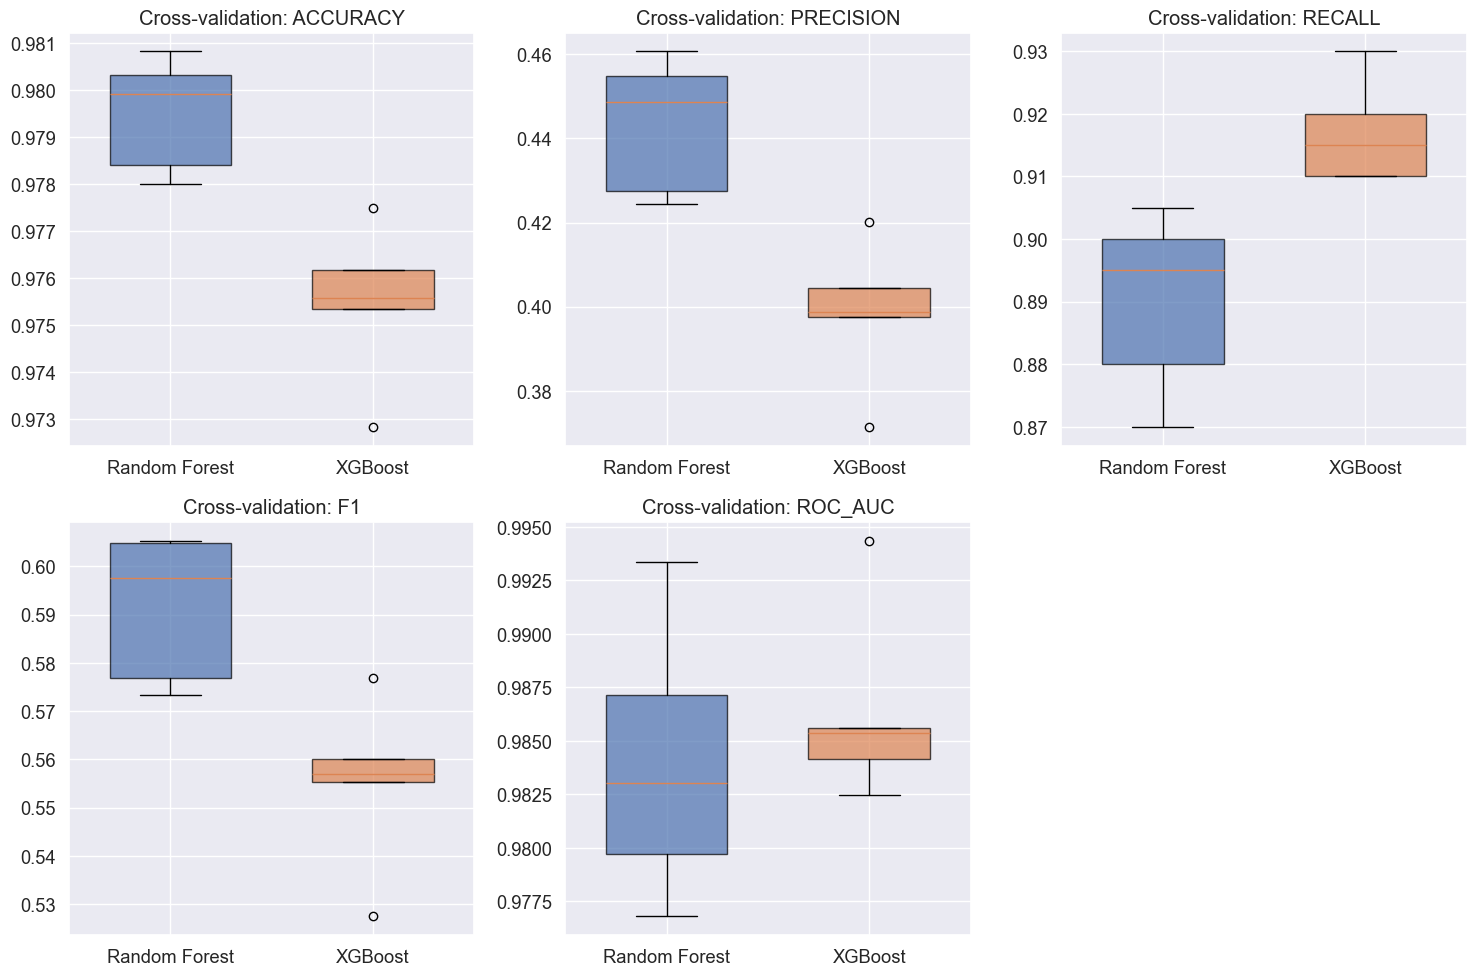

In [4]:
# Define a function to evaluate models with cross-validation
def evaluate_model_with_cv(model, X, y, cv=5, scoring='f1'):
    """
    Evaluate a model using cross-validation
    
    Parameters:
    -----------
    model : estimator
        The model to evaluate
    X : array-like
        Features
    y : array-like
        Target variable
    cv : int
        Number of cross-validation folds
    scoring : str
        Scoring metric
        
    Returns:
    --------
    cv_scores : numpy.ndarray
        Cross-validation scores
    """
    # Use StratifiedKFold for imbalanced classification
    cv_splitter = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cv_scores = cross_val_score(
        model, X, y, 
        cv=cv_splitter,
        scoring=scoring,
        n_jobs=-1
    )
    
    return cv_scores

# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    )
}

# Evaluate models with cross-validation
print("Evaluating models with 5-fold cross-validation...")
cv_results = {}
cv_folds = 5
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    model_cv_results = {}
    
    for metric in scoring_metrics:
        print(f"  Scoring with {metric}...")
        cv_scores = evaluate_model_with_cv(model, X_train_top, y_train, cv=cv_folds, scoring=metric)
        model_cv_results[metric] = cv_scores
        print(f"    Mean {metric}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    cv_results[model_name] = model_cv_results

# Create a summary DataFrame
cv_summary = pd.DataFrame(columns=['Model'] + scoring_metrics)

for i, (model_name, model_cv_results) in enumerate(cv_results.items()):
    row = {'Model': model_name}
    for metric in scoring_metrics:
        scores = model_cv_results[metric]
        row[metric] = f"{scores.mean():.4f} ± {scores.std():.4f}"
    cv_summary.loc[i] = row

print("\nCross-validation summary:")
display(cv_summary)

# Plot cross-validation results
plt.figure(figsize=(15, 10))

for i, metric in enumerate(scoring_metrics):
    plt.subplot(2, 3, i+1)
    
    for j, model_name in enumerate(models.keys()):
        scores = cv_results[model_name][metric]
        plt.boxplot(scores, positions=[j+1], widths=0.6, patch_artist=True,
                   boxprops=dict(facecolor=f'C{j}', alpha=0.7))
    
    plt.title(f'Cross-validation: {metric.upper()}')
    plt.xticks(range(1, len(models)+1), models.keys())
    plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


### Step 5.3: Hyperparameter Tuning for Classification Models


Performing hyperparameter tuning for Random Forest...
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best Random Forest parameters: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 score: 0.7458

Performing hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits

Best XGBoost parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 5, 'subsample': 1.0}
Best F1 score: 0.7755

Evaluating the best models on the test set...

Random Forest (tuned) Test Results:
  Accuracy: 0.9912
  Precision: 0.8679
  Recall: 0.7360
  F1 Score: 0.7965
  ROC AUC: 0.9888

XGBoost (tuned) Test Results:
  Accuracy: 0.9919
  Precision: 0.8412
  Recall: 0.8053
  F1 Score: 0.8229
  ROC AUC: 0.9926

Test results summary:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest (tuned),0.991187,0.867925,0.736000,0.796537,0.988817
1,XGBoost (tuned),0.991875,0.841226,0.805333,0.822888,0.992550


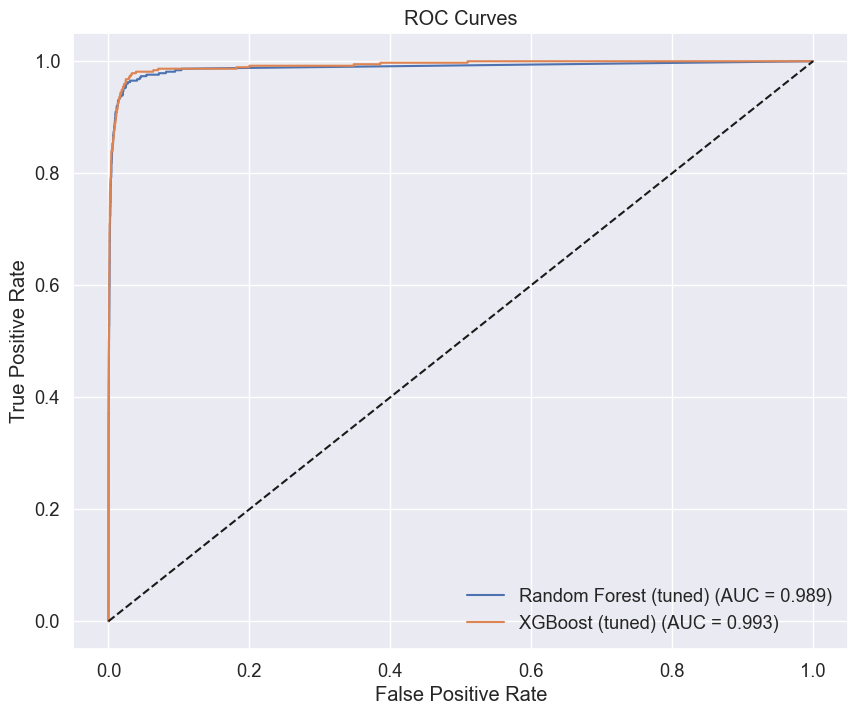

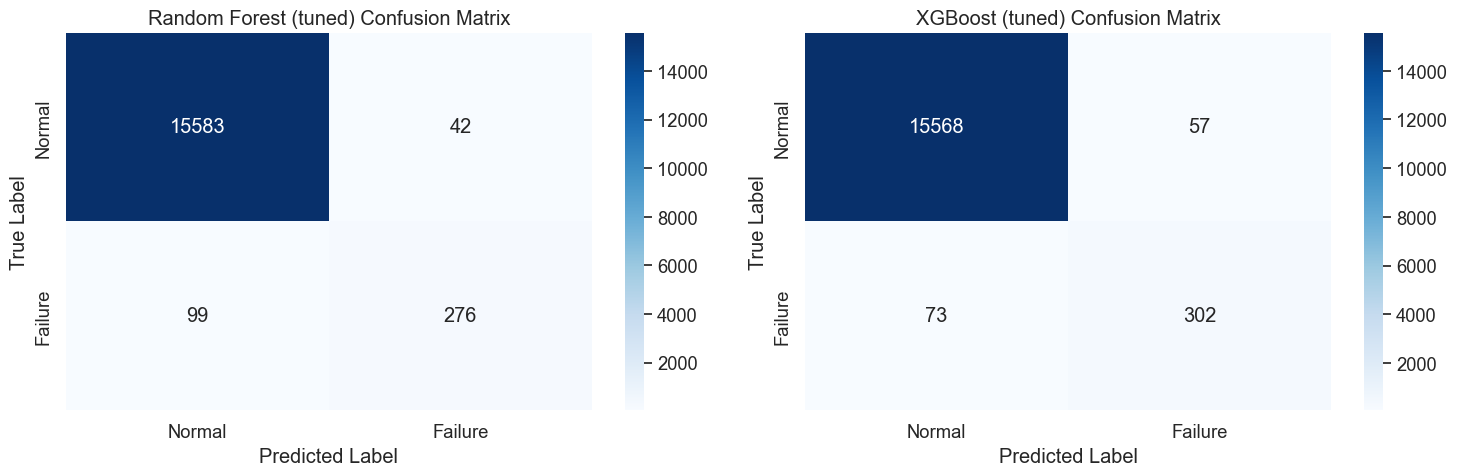


Best model selected: XGBoost (tuned)
F1 Score: 0.8229

Best model saved to ../src/model_evaluation/best_classification_model.pkl


In [5]:
# Hyperparameter tuning for Random Forest
print("Performing hyperparameter tuning for Random Forest...")

# Define the parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Use StratifiedKFold for imbalanced classification
cv_splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create the grid search
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv_splitter,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
rf_grid_search.fit(X_train_top, y_train)

# Print the best parameters and score
print(f"\nBest Random Forest parameters: {rf_grid_search.best_params_}")
print(f"Best F1 score: {rf_grid_search.best_score_:.4f}")

# Get the best model
best_rf = rf_grid_search.best_estimator_

# Hyperparameter tuning for XGBoost
print("\nPerforming hyperparameter tuning for XGBoost...")

# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

# Create the grid search
xgb_grid_search = GridSearchCV(
    xgb.XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    param_grid=xgb_param_grid,
    cv=cv_splitter,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
xgb_grid_search.fit(X_train_top, y_train)

# Print the best parameters and score
print(f"\nBest XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best F1 score: {xgb_grid_search.best_score_:.4f}")

# Get the best model
best_xgb = xgb_grid_search.best_estimator_

# Compare the best models
best_models = {
    'Random Forest (tuned)': best_rf,
    'XGBoost (tuned)': best_xgb
}

# Evaluate the best models on the test set
print("\nEvaluating the best models on the test set...")
test_results = {}

for model_name, model in best_models.items():
    # Make predictions
    y_pred = model.predict(X_test_top)
    y_pred_proba = model.predict_proba(X_test_top)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store results
    test_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'fpr': fpr,
        'tpr': tpr
    }
    
    print(f"\n{model_name} Test Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")

# Create a summary DataFrame
test_summary = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

for i, (model_name, results) in enumerate(test_results.items()):
    test_summary.loc[i] = [
        model_name,
        results['accuracy'],
        results['precision'],
        results['recall'],
        results['f1'],
        results['roc_auc']
    ]

print("\nTest results summary:")
display(test_summary)

# Plot ROC curves
plt.figure(figsize=(10, 8))

for model_name, results in test_results.items():
    plt.plot(results['fpr'], results['tpr'], 
             label=f"{model_name} (AUC = {results['roc_auc']:.3f})")

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(1, len(best_models), figsize=(15, 5))

for i, (model_name, results) in enumerate(test_results.items()):
    cm = confusion_matrix(y_test, results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Failure'],
                yticklabels=['Normal', 'Failure'],
                ax=axes[i])
    axes[i].set_title(f'{model_name} Confusion Matrix')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Select the best model based on F1 score
best_model_name = test_summary.loc[test_summary['F1 Score'].idxmax(), 'Model']
best_model = best_models[best_model_name]

print(f"\nBest model selected: {best_model_name}")
print(f"F1 Score: {test_summary.loc[test_summary['F1 Score'].idxmax(), 'F1 Score']:.4f}")

# Save the best model
model_filename = f"../src/model_evaluation/best_classification_model.pkl"
os.makedirs(os.path.dirname(model_filename), exist_ok=True)
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"\nBest model saved to {model_filename}")
